# Языковые модели и RNN


Будем рассматривать языковые модели на примере задачи генерации названий динозавров.

Обучим две различные символьные языковые модели:
* вероятностная модель на символьных биграммах
* ***RNN***-модель.



## Счетная языковая модель


Счетная языковая модель (или count-based language model) — это тип языковой модели, который основывается на статистических данных о частоте встречаемости слов и их последовательностей в текстах. Такие модели используют количество появлений слов и их комбинаций для оценки вероятностей и предсказания следующих слов в предложении.

[Генератор текста на основе цепей Маркова](https://tproger.ru/translations/markov-chains)

$$ P(W ) = P(w_{1} , . . . , w_{n} ) ≈ \prod_{i}	 P(w_{i} |w_{i−1} ) $$

In [3]:
!wget https://raw.githubusercontent.com/artemovae/NLP-seminar-LM/master/dinos.txt

--2025-03-19 22:41:00--  https://raw.githubusercontent.com/artemovae/NLP-seminar-LM/master/dinos.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19909 (19K) [text/plain]
Saving to: ‘dinos.txt’

dinos.txt           100%[===================>]  19.44K  --.-KB/s    in 0s      

2025-03-19 22:41:00 (116 MB/s) - ‘dinos.txt’ saved [19909/19909]



In [2]:
!cat dinos.txt | head

cat: dinos.txt: No such file or directory


In [4]:
names = ['<' + name.strip().lower() + '>' for name in open('dinos.txt').readlines()]
print(names[:10])

['<aachenosaurus>', '<aardonyx>', '<abdallahsaurus>', '<abelisaurus>', '<abrictosaurus>', '<abrosaurus>', '<abydosaurus>', '<acanthopholis>', '<achelousaurus>', '<acheroraptor>']


In [5]:
import nltk

Вычислим частоту каждого символа в корпусе имен динозавров.

In [6]:
chars = [char for name in names for char in name]
freq = nltk.FreqDist(chars)

In [7]:
freq

FreqDist({'a': 2487, 's': 2285, 'u': 2123, 'o': 1710, 'r': 1704, '<': 1536, '>': 1536, 'n': 1081, 'i': 944, 'e': 913, ...})

In [8]:
print(len(list(freq.keys())))

28


In [9]:
freq.most_common(10)

[('a', 2487),
 ('s', 2285),
 ('u', 2123),
 ('o', 1710),
 ('r', 1704),
 ('<', 1536),
 ('>', 1536),
 ('n', 1081),
 ('i', 944),
 ('e', 913)]

Функция для вычисления вероятности появления каждого символа:

In [10]:
l = sum([freq[char] for char in freq])
def unigram_prob(char):
    return freq[char] / l

In [11]:
print('p(a) = %1.4f' %unigram_prob('a'))

p(a) = 0.1160


Вычислим условную вероятность каждого символа в зависимости от того, какой символ стоял на предыдущей позиции.

In [12]:
cfreq = nltk.ConditionalFreqDist(nltk.bigrams(chars))

In [13]:
cfreq['a']

FreqDist({'u': 791, 'n': 347, 't': 204, 's': 171, 'l': 138, '>': 138, 'r': 124, 'c': 100, 'p': 89, 'm': 68, ...})

Оценим условные вероятности с помощью MLE.

In [14]:
cprob = nltk.ConditionalProbDist(cfreq, nltk.MLEProbDist)

In [15]:
print('p(a a) = %1.4f' %cprob['a'].prob('a'))
print('p(a b) = %1.4f' %cprob['a'].prob('b'))
print('p(a u) = %1.4f' %cprob['a'].prob('u'))

p(a a) = 0.0044
p(a b) = 0.0097
p(a u) = 0.3181


In [16]:
cprob['a'].generate()

'u'

Напишем функцию для генерации названия динозавра **фиксированной** длины. Используем '<' в качестве символа начала последовательности.

In [17]:
 def generate_n_word(n=10):
    word = '<'
    for i in range(n):
        word += cprob[word[-1]].generate()
    word += '>'
    return word

In [18]:
generate_n_word()

'<s><vocaur>>'

## Реккурентные нейронные сети (RNN)

Исходная последовательность:

$x_{1:n} = x_1, x_2, \ldots, x_n$, $x_i \in \mathbb{R}^{d_{in}}$

Для каждого входного значения $x_{1:i}$ получаем на выходе $y_i$:

$y_i = RNN(x_{1:i})$, $y_i \in \mathbb{R}^{d_{out}}$

Для всей последовательности $x_{1:n}$:

$y_{1:n} = RNN^{*}(x_{1:n})$, $y_i \in \mathbb{R}^{d_{out}}$

$R$ - рекурсивная функция активации, зависящая от двух параметров: $x_i$ и $s_{i-1}$ (вектор предыдущего состояния)

$RNN^{*}(x_{1:n}, s_0) = y_{1:n}$

$y_i = O(s_i) = g(W^{out}[s_{i} ,x_i] +b)$

$s_i = R(s_{i-1}, x_i)$

$s_i = R(s_{i-1}, x_i) = g(W^{hid}[s_{i-1} ,x_i] +b)$  -- конкатенация $[s_{i-1}, x]$

$x_i \in \mathbb{R}^{d_{in}}$, $y_i \in \mathbb{R}^{ d_{out}}$, $s_i \in \mathbb{R}^{d_{hid}}$

$W^{hid} \in \mathbb{R}^{(d_{in}+d_{out}) \times d_{hid}}$, $W^{out} \in \mathbb{R}^{d_{hid} \times d_{out}}$

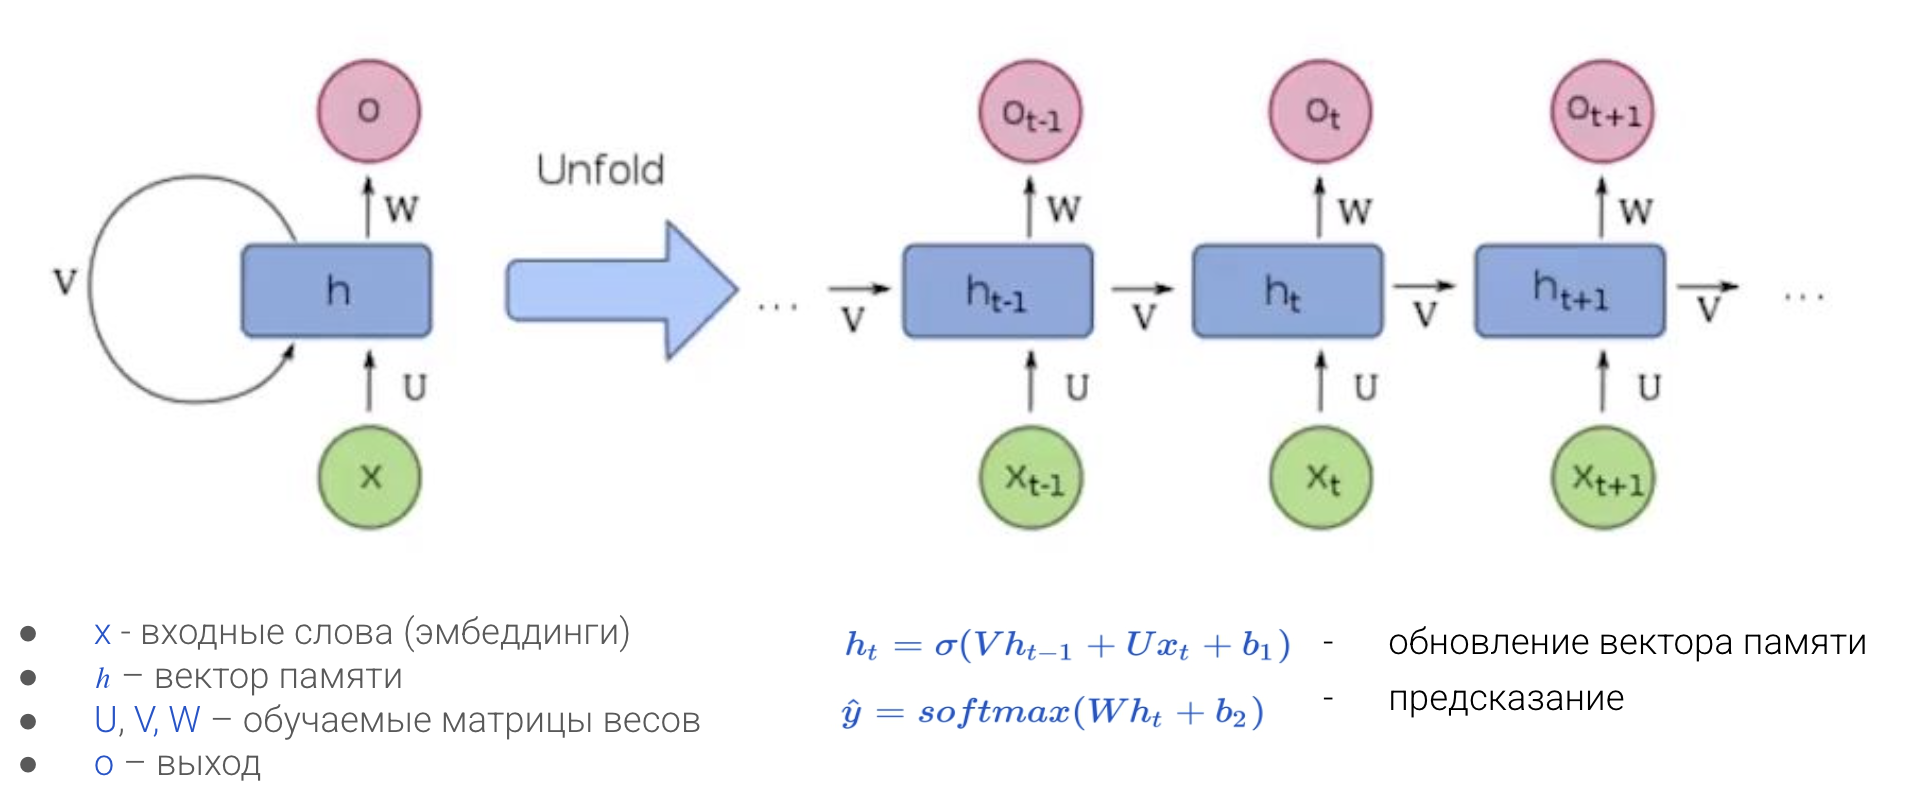

Построим языковую модель на основе RNN с помощью pytorch.

In [19]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import pdb
from torch.utils.data import Dataset, DataLoader

%load_ext autoreload
%autoreload 2

torch.set_printoptions(linewidth=200)

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
hidden_size = 50

Подготовим данные

In [ ]:
class DinosDataset(Dataset):
    def __init__(self):
        super().__init__()
        with open('dinos.txt') as f:
            content = f.read().lower()
            self.vocab = sorted(set(content)) + ['<', '>']
            self.vocab_size = len(self.vocab)
            self.lines = content.splitlines()
        self.ch_to_idx = {c:i for i, c in enumerate(self.vocab)}
        self.idx_to_ch = {i:c for i, c in enumerate(self.vocab)}

    def __getitem__(self, index):
        line = self.lines[index]
        #teacher forcing
        x_str = '<' + line
        y_str = line + '>'
        x = torch.zeros([len(x_str), self.vocab_size], dtype=torch.float)
        y = torch.empty(len(x_str), dtype=torch.long)
        for i, (x_ch, y_ch) in enumerate(zip(x_str, y_str)):
            x[i][self.ch_to_idx[x_ch]] = 1
            y[i] = self.ch_to_idx[y_ch]

        return x, y

    def __len__(self):
        return len(self.lines)

In [ ]:
trn_ds = DinosDataset()
trn_dl = DataLoader(trn_ds, shuffle=True)

In [ ]:
trn_ds.lines[1]

'aardonyx'

In [ ]:
print(trn_ds.idx_to_ch)

{0: '\n', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 27: '<', 28: '>'}


In [ ]:
trn_ds.vocab_size

29

In [ ]:
x, y = trn_ds[1]

In [ ]:
x.shape

torch.Size([9, 29])

In [ ]:
y.shape

torch.Size([9])

In [ ]:
x

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0

In [ ]:
y

tensor([ 1,  1, 18,  4, 15, 14, 25, 24, 28])

Опишем модель, функцию потерь и алгоритм оптимизации

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.dropout = nn.Dropout(0.3)
        self.i2o = nn.Linear(hidden_size, output_size)

    def forward(self, h_prev, x):
        combined = torch.cat([h_prev, x], dim = 1) # concatenate x and h
        h = torch.tanh(self.dropout(self.i2h(combined)))
        y = self.i2o(h)
        return h, y

In [ ]:
model = RNN(trn_ds.vocab_size, hidden_size, trn_ds.vocab_size).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2)

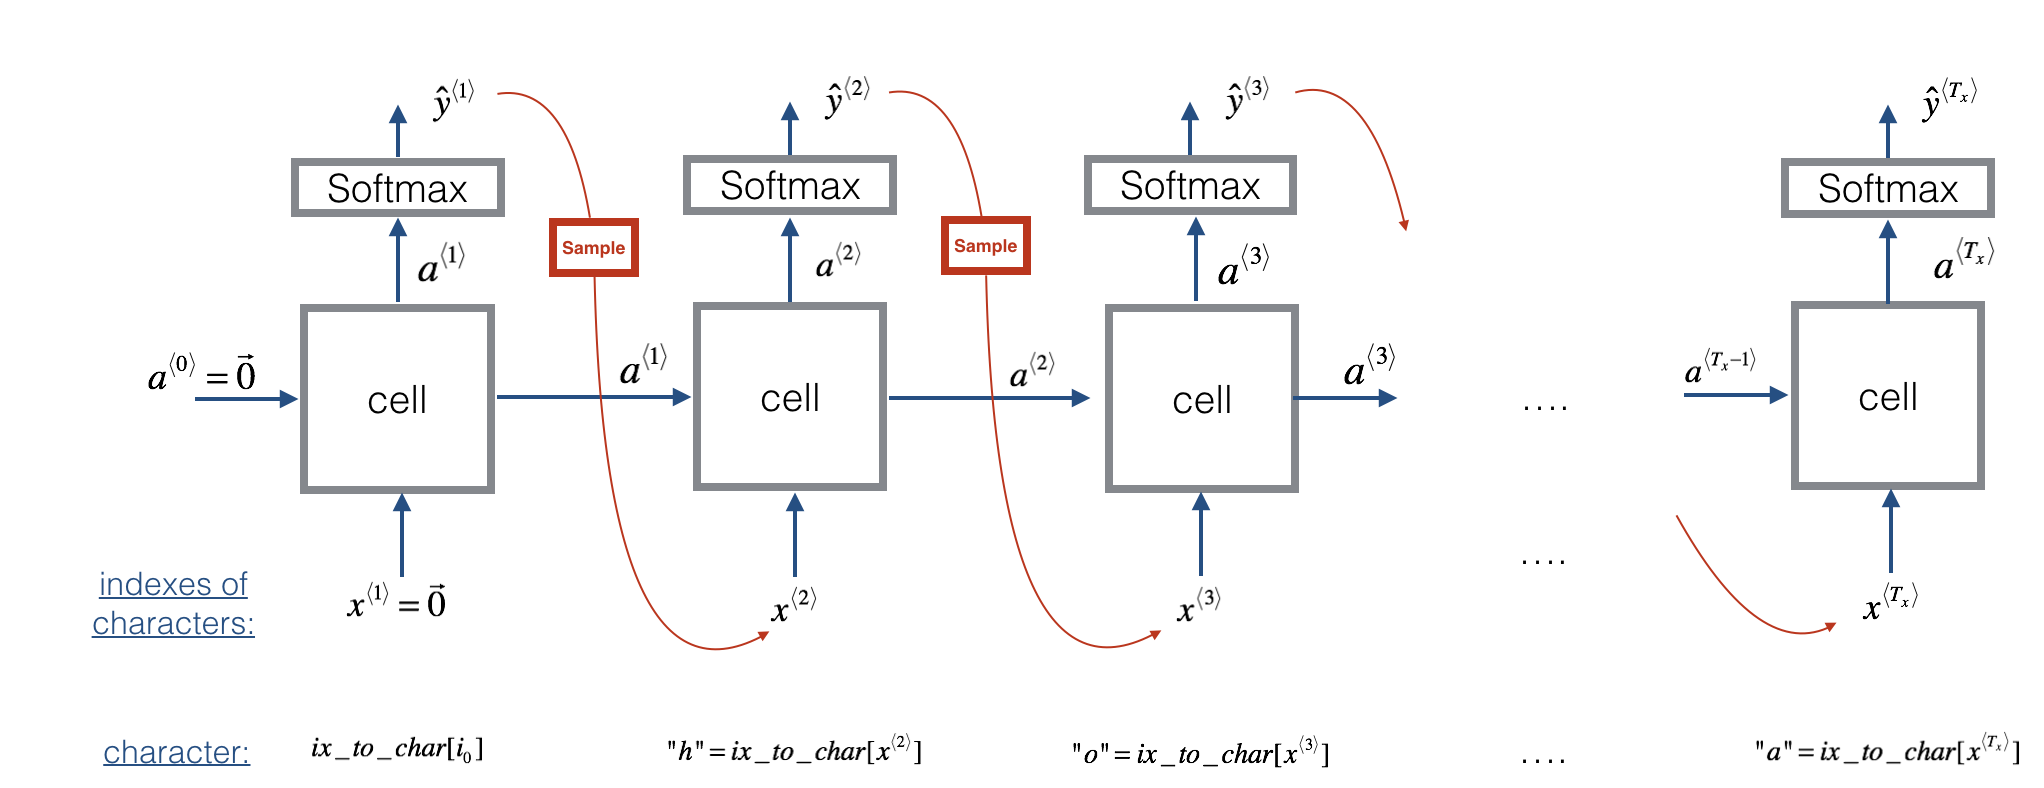

In [ ]:
def sample(model):
    model.eval()
    word_size=0
    newline_idx = trn_ds.ch_to_idx['>']
    with torch.no_grad():
        h_prev = torch.zeros([1, hidden_size], dtype=torch.float, device=device)
        x = h_prev.new_zeros([1, trn_ds.vocab_size])
        start_char_idx = trn_ds.ch_to_idx['<']
        indices = [start_char_idx]
        x[0, start_char_idx] = 1
        predicted_char_idx = start_char_idx

        while predicted_char_idx != newline_idx and word_size != 50:
            h_prev, y_pred = model(h_prev, x)
            y_softmax_scores = torch.softmax(y_pred, dim=1)

            np.random.seed(np.random.randint(1, 5000))
            idx = np.random.choice(np.arange(trn_ds.vocab_size), p=y_softmax_scores.cpu().numpy().ravel())
            indices.append(idx)

            # x = (y_pred == y_pred.max(1)[0]).float()
            x = h_prev.new_zeros([1, trn_ds.vocab_size])
            x[0, idx] = 1

            predicted_char_idx = idx

            word_size += 1

        if word_size == 50:
            indices.append(newline_idx)
    return indices

In [ ]:
def print_sample(sample_idxs):
    [print(trn_ds.idx_to_ch[x], end ='') for x in sample_idxs]
    print()

Обучим получившуюся модель

In [ ]:
def train_one_epoch(model, loss_fn, optimizer):
    model.train()
    for line_num, (x, y) in enumerate(trn_dl):
        loss = 0
        optimizer.zero_grad()
        h_prev = torch.zeros([1, hidden_size], dtype=torch.float, device=device)
        x, y = x.to(device), y.to(device)
        for i in range(x.shape[1]):
            h_prev, y_pred = model(h_prev, x[:, i])
            loss += loss_fn(y_pred, y[:, i])

        if (line_num+1) % 100 == 0:
            print_sample(sample(model))
        loss.backward()
        optimizer.step()

In [ ]:
def train(model, loss_fn, optimizer, dataset='dinos', epochs=1):
    for e in range(1, epochs+1):
        print('Epoch:{}'.format(e))
        train_one_epoch(model, loss_fn, optimizer)
        print()

In [ ]:
train(model, loss_fn, optimizer, epochs = 10)

Epoch:1
<isoatabroousrenuaiersgsuu>
<pxmiaetesouausouturururerudh>
<oeionemv>
<neeonaurun>
<alus>
<ctrrlerop>
<tippsannanrascunus>
<apethiatan>
<pucustonspous>
<rusarochua>
<gtadosaurus>
<auanyotaus>
<meronysaurui>
<lalrathun>
<saancongaueus>

Epoch:2
<vatoriesos>
<satruanianue>
<guagonasaurus>
<apurulus>
<lepseuscorua>
<laloconyalustthus>
<auchusulus>
<marooxtistukus>
<ftardradopa>
<crigasausus>
<strngros>
<saptocena>
<sashucerhaphus>
<auanwosaurus>
<slivonptochianodon>

Epoch:3
<airochas>
<jaranwosaurus>
<silwosauros>
<alrathuaus>
<aneuilataosaurus>
<leopiytis>
<tanganoclosaurul>
<concasaurus>
<strlasaus>
<lostanlanta>
<huagrnasaurus>
<aouquisaurus>
<hyristoceraton>
<eualonatethia>
<amvosaurus>

Epoch:4
<pliwonosasius>
<sauhuahorasaurus>
<amuruntosaurus>
<sarruania>
<sasauaesachus>
<iatanysokosaurus>
<zrlostaosaurus>
<tajrochesaurus>
<xrucosbsaurus>
<mortatodhoesaurus>
<anbtona>
<anvosaurus>
<ronythoscaregkuosaurus>
<ancrodasaurus>
<strolornythus>

Epoch:5
<amjanodon>
<agrianesaurus>

In [ ]:
print_sample(sample(model))

<witastongx>


In [ ]:
generate_n_word()

'<ptesaphura>'

## Ссылки

1. Sampling in  RNN: https://nlp.stanford.edu/blog/maximum-likelihood-decoding-with-rnns-the-good-the-bad-and-the-ugly/
2. Coursera course (main source): https://github.com/furkanu/deeplearning.ai-pytorch/tree/master/5-%20Sequence%20Models
3. Coursera course (main source): https://github.com/Kulbear/deep-learning-coursera/blob/master/Sequence%20Models/Dinosaurus%20Island%20--%20Character%20level%20language%20model%20final%20-%20v3.ipynb
4. LSTM: http://colah.github.io/posts/2015-08-Understanding-LSTMs/

## Мультиклассовая текстовая классификация

Будем предсказывать рейтинг на основе отзывов пользователей на основе этого набора данных:
https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews

In [ ]:
!pip install spacy

In [ ]:
import pandas as pd
from collections import Counter
import spacy
import re
import string
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.metrics import mean_squared_error
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1N6bIhcoHQJhPM1XzdGlM_jCiQTOmtHi1' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1N6bIhcoHQJhPM1XzdGlM_jCiQTOmtHi1" -O reviews.csv && rm -rf /tmp/cookies.txt

--2025-03-19 12:34:57--  https://docs.google.com/uc?export=download&confirm=&id=1N6bIhcoHQJhPM1XzdGlM_jCiQTOmtHi1
Resolving docs.google.com (docs.google.com)... 108.177.98.139, 108.177.98.113, 108.177.98.138, ...
Connecting to docs.google.com (docs.google.com)|108.177.98.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1N6bIhcoHQJhPM1XzdGlM_jCiQTOmtHi1&export=download [following]
--2025-03-19 12:34:57--  https://drive.usercontent.google.com/download?id=1N6bIhcoHQJhPM1XzdGlM_jCiQTOmtHi1&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.142.132, 2607:f8b0:400e:c08::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.142.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8483448 (8.1M) [application/octet-stream]
Saving to: ‘reviews.csv’

reviews.csv         100%[===================>]   8.09M  --.-KB/

Загрузим данные и посмотрим на них:

In [ ]:
#loading the data
reviews = pd.read_csv("reviews.csv")
print(reviews.shape)
reviews.head()

(23486, 11)


,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


В качестве текста отзыва будем использовать заголовок исам отзыв:

In [ ]:
reviews['Title'] = reviews['Title'].fillna('')
reviews['Review Text'] = reviews['Review Text'].fillna('')
reviews['review'] = reviews['Title'] + ' ' + reviews['Review Text']

Сохраним только релевантные колонки и посчитаем длину каждого отзыва:

In [ ]:
#keeping only relevant columns and calculating sentence lengths
reviews = reviews[['review', 'Rating']]
reviews.columns = ['review', 'rating']
reviews['review_length'] = reviews['review'].apply(lambda x: len(x.split()))
reviews.head()

<ipython-input-11-f396e62b1fb4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews['review_length'] = reviews['review'].apply(lambda x: len(x.split()))


,review,rating,review_length
0,Absolutely wonderful - silky and sexy and com...,4,8
1,Love this dress! it's sooo pretty. i happen...,5,62
2,Some major design flaws I had such high hopes ...,3,102
3,"My favorite buy! I love, love, love this jumps...",5,25
4,Flattering shirt This shirt is very flattering...,5,38


Поменяем рейтинги с диапазона от [1:5] на диапазон: [0:4]:

In [ ]:
#changing ratings to 0-numbering
zero_numbering = {1:0, 2:1, 3:2, 4:3, 5:4}
reviews['rating'] = reviews['rating'].apply(lambda x: zero_numbering[x])

Средняя длина предложения в отзывах:

In [ ]:
#mean sentence length
np.mean(reviews['review_length'])

60.832921740611425

### Препроцессим тексты

Токенизируем и удалим все цифры и пунктуацию:

In [ ]:
#tokenization
tok = spacy.load("en_core_web_sm")
def tokenize (text):
    text = re.sub(r"[^\x00-\x7F]+", " ", text)
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]') # remove punctuation and numbers
    nopunct = regex.sub(" ", text.lower())
    return [token.text for token in tok.tokenizer(nopunct)]

Выделим наиболее частые токены:

In [ ]:
#count number of occurences of each word
counts = Counter()
for index, row in reviews.iterrows():
    counts.update(tokenize(row['review']))

In [ ]:
#deleting infrequent words
print("num_words before:",len(counts.keys()))
for word in list(counts):
    if counts[word] < 2:
        del counts[word]
print("num_words after:",len(counts.keys()))

num_words before: 14138
num_words after: 8263


Создадим словарь всех уникальных слов, которые мы взяли в рассмотрение и пронумеруем каждо слово:

In [ ]:
#creating vocabulary
vocab2index = {"":0, "UNK":1}
words = ["", "UNK"]
for word in counts:
    vocab2index[word] = len(words)
    words.append(word)

Закодируем отзывы с помощью порядковых номеров слов в словаре. Добавим в начало словаря токен пустого слова и токены для неизвестных слов:

In [ ]:
def encode_sentence(text, vocab2index, N=70):
    tokenized = tokenize(text)
    encoded = np.zeros(N, dtype=int)
    enc1 = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized])
    length = min(N, len(enc1))
    encoded[:length] = enc1[:length]
    return [encoded, length]

In [ ]:
reviews['encoded'] = reviews['review'].apply(lambda x: encode_sentence(x,vocab2index ))
reviews.head()

,review,rating,review_length,encoded
0,Absolutely wonderful - silky and sexy and com...,3,8,"[[2, 3, 4, 5, 6, 7, 8, 7, 9, 0, 0, 0, 0, 0, 0,..."
1,Love this dress! it's sooo pretty. i happen...,4,62,"[[2, 10, 11, 12, 5, 13, 14, 15, 16, 5, 17, 18,..."
2,Some major design flaws I had such high hopes ...,2,102,"[[54, 55, 56, 57, 17, 58, 59, 60, 61, 62, 11, ..."
3,"My favorite buy! I love, love, love this jumps...",4,25,"[[68, 109, 110, 2, 17, 10, 2, 10, 2, 10, 11, 1..."
4,Flattering shirt This shirt is very flattering...,4,38,"[[122, 123, 11, 123, 52, 92, 122, 19, 124, 125..."


Посмотрим на статистику распределения отзывов по рейтингам:

In [ ]:
#check how balanced the dataset is
Counter(reviews['rating'])

Counter({3: 5077, 4: 13131, 2: 2871, 1: 1565, 0: 842})

Разобьем данные на обучающие, валидационные и тестовые:

In [ ]:
X = list(reviews['encoded'])
y = list(reviews['rating'])
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

Создадим класс для на основе класса Dataset из библиотеки Pytorch для удобной итерации данных:

In [ ]:
class ReviewsDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.y = Y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx][0].astype(np.int32)), self.y[idx], self.X[idx][1]

In [ ]:
train_ds = ReviewsDataset(X_train, y_train)
valid_ds = ReviewsDataset(X_valid, y_valid)
test_ds = ReviewsDataset(X_test, y_test)

#### Методы для обучения и оценки моделей

In [ ]:
def train_model(model, epochs=10, lr=0.001):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=lr)
    for i in range(epochs):
        model.train()
        sum_loss = 0.0
        total = 0
        for x, y, l in train_dl:
            x = x.long()
            y = y.long()
            y_pred = model(x, l)
            optimizer.zero_grad()
            loss = F.cross_entropy(y_pred, y)
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()*y.shape[0]
            total += y.shape[0]
        val_loss, val_acc, val_rmse = validation_metrics(model, val_dl)
        if i % 5 == 1:
            print("train loss %.3f, val loss %.3f, val accuracy %.3f, and val rmse %.3f" % (sum_loss/total, val_loss, val_acc, val_rmse))

def validation_metrics (model, valid_dl):
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    sum_rmse = 0.0
    for x, y, l in valid_dl:
        x = x.long()
        y = y.long()
        y_hat = model(x, l)
        loss = F.cross_entropy(y_hat, y)
        pred = torch.max(y_hat, 1)[1]
        correct += (pred == y).float().sum()
        total += y.shape[0]
        sum_loss += loss.item()*y.shape[0]
        sum_rmse += np.sqrt(mean_squared_error(pred, y.unsqueeze(-1)))*y.shape[0]
    return sum_loss/total, correct/total, sum_rmse/total

In [ ]:
batch_size = 512
vocab_size = len(words)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(valid_ds, batch_size=batch_size)
test_dl = DataLoader(test_ds, batch_size=batch_size)

### LSTM с фиксированной длиной входа

Сеть с долгой краткосрочной памятью (Long short-term memory; LSTM) – особая разновидность архитектуры рекуррентных нейронных сетей, способная к обучению долговременным зависимостям. Ключевой компонент LSTM – это состояние ячейки (cell state) – горизонтальная линия, проходящая по верхней части схемы.

Почитать подробнее: [источник](https://habr.com/ru/companies/wunderfund/articles/331310/)


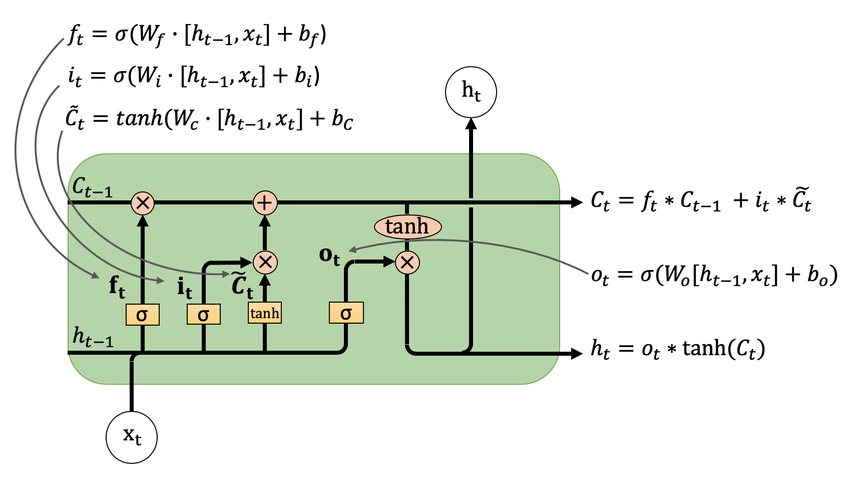

[Источник картинки](https://www.researchgate.net/figure/Complete-LSTM-architecture-with-equations-showing-how-information-moves-through-the-cell_fig2_351291905)

In [ ]:
class LSTM_fixed_len(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim) :
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 5)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x, l):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, (ht, ct) = self.lstm(x)
        return self.linear(ht[-1])

In [ ]:
model_fixed =  LSTM_fixed_len(vocab_size, 50, 50)

In [ ]:
train_model(model_fixed, epochs=30, lr=0.01)

train loss 1.192, val loss 1.214, val accuracy 0.560, and val rmse 1.396
train loss 0.955, val loss 1.087, val accuracy 0.580, and val rmse 1.036
train loss 0.772, val loss 0.989, val accuracy 0.612, and val rmse 0.898
train loss 0.626, val loss 1.040, val accuracy 0.620, and val rmse 0.871
train loss 0.520, val loss 1.098, val accuracy 0.613, and val rmse 0.853
train loss 0.481, val loss 1.190, val accuracy 0.608, and val rmse 0.885


### LSTM со входами различной длины

In [ ]:
class LSTM_variable_input(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim) :
        super().__init__()
        self.hidden_dim = hidden_dim
        self.dropout = nn.Dropout(0.3)
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 5)

    def forward(self, x, l):
        x = self.embeddings(x)
        x = self.dropout(x)
        x_pack = pack_padded_sequence(x, l, batch_first=True, enforce_sorted=False)
        out_pack, (ht, ct) = self.lstm(x_pack)
        out = self.linear(ht[-1])
        return out

In [ ]:
model = LSTM_variable_input(vocab_size, 50, 50)

In [ ]:
train_model(model, epochs=30, lr=0.1)

train loss 1.102, val loss 1.102, val accuracy 0.557, and val rmse 1.180
train loss 1.036, val loss 1.111, val accuracy 0.568, and val rmse 1.174
train loss 1.018, val loss 1.070, val accuracy 0.569, and val rmse 1.101
train loss 0.992, val loss 1.056, val accuracy 0.587, and val rmse 1.081
train loss 1.006, val loss 1.087, val accuracy 0.571, and val rmse 1.066
train loss 1.015, val loss 1.096, val accuracy 0.580, and val rmse 1.133


### LSTM с предобученными Glove векторами

В предыдущих примерах мы генерировали векторное представление слов случайным образом, попробуем инициализировать слой векторного представления слов векторами из модели Glove.

Скачиваем предобученную модель : https://nlp.stanford.edu/projects/glove/

In [ ]:
!wget https://nlp.stanford.edu/data/glove.6B.zip

--2025-03-19 10:52:12--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-03-19 10:52:12--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.01MB/s    in 2m 41s  

2025-03-19 10:54:53 (5.10 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [ ]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


Загрузим вектора для каждого слова:

In [ ]:
def load_glove_vectors(glove_file="glove.6B.50d.txt"):
    """Load the glove word vectors"""
    word_vectors = {}
    with open(glove_file) as f:
        for line in f:
            split = line.split()
            word_vectors[split[0]] = np.array([float(x) for x in split[1:]])
    return word_vectors

In [ ]:
def get_emb_matrix(pretrained, word_counts, emb_size = 50):
    """ Creates embedding matrix from word vectors"""
    vocab_size = len(word_counts) + 2
    vocab_to_idx = {}
    vocab = ["", "UNK"]
    W = np.zeros((vocab_size, emb_size), dtype="float32")
    W[0] = np.zeros(emb_size, dtype='float32') # adding a vector for padding
    W[1] = np.random.uniform(-0.25, 0.25, emb_size) # adding a vector for unknown words
    vocab_to_idx["UNK"] = 1
    i = 2
    for word in word_counts:
        if word in word_vecs:
            W[i] = word_vecs[word]
        else:
            W[i] = np.random.uniform(-0.25,0.25, emb_size)
        vocab_to_idx[word] = i
        vocab.append(word)
        i += 1
    return W, np.array(vocab), vocab_to_idx

In [ ]:
word_vecs = load_glove_vectors()
pretrained_weights, vocab, vocab2index = get_emb_matrix(word_vecs, counts)

In [ ]:
class LSTM_glove_vecs(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim, glove_weights) :
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.embeddings.weight.data.copy_(torch.from_numpy(glove_weights))
        # self.embeddings.weight.requires_grad = False ## freeze embeddings
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 5)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x, l):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, (ht, ct) = self.lstm(x)
        return self.linear(ht[-1])

In [ ]:
model = LSTM_glove_vecs(vocab_size, 50, 50, pretrained_weights)

In [ ]:
train_model(model, epochs=30, lr=0.1)